In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
llm=ChatGroq(model="qwen-qwq-32b")

result = llm.invoke("Hi, I am an Aspiring AI Engineer")
result

AIMessage(content="\n<think>\nOkay, the user introduced themselves as an aspiring AI engineer. I need to respond in a friendly and encouraging way. Let me start by welcoming them and acknowledging their interest.\n\nNext, I should provide some actionable steps to help them get started. Maybe suggest learning the fundamentals like linear algebra and calculus since those are crucial. Also, programming languages like Python are essential, so I'll mention that.\n\nThey might be interested in knowing about machine learning frameworks. TensorFlow and PyTorch are the big ones, so I'll include those. It's important to recommend building projects because hands-on experience is key. Maybe suggest starting with small projects like a linear regression model or a basic neural network.\n\nI should also mention getting familiar with data handling and analysis using libraries like Pandas and NumPy. Explaining the importance of data in AI projects would be good here.\n\nIncluding some resources like on

## Prompt Chaining

In [5]:
from pydantic import BaseModel, StrictInt, StrictStr

class State(BaseModel):
    topic: str
    story: str = ""
    improved_story: str = ""
    final_story: str = ""

def generate_story(state: State):
    msg = llm.invoke(f"Write a paragraph story on this topic in 50 words: {state.topic}")
    return {"story": msg.content}

def check_conflict(state: State):
    if "?" in state.story:
        return "Fail"
    return "Pass"

def improve_story(state: State):
    msg = llm.invoke(f"Enhance the story focusing on important details: {state.story}")
    return {"improved_story": msg.content}

def polish_story(state: State):
    msg = llm.invoke(f"Polish this story: {state.improved_story}")
    return {"final_story": msg.content}

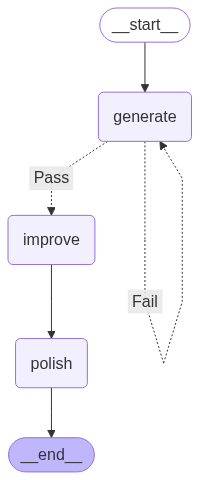

In [6]:
#Build the graph

from langgraph.graph import StateGraph, START, END
from IPython.display import display, Image

graph = StateGraph(State)

graph.add_node('generate', generate_story)
graph.add_node('improve', improve_story)
graph.add_node('polish', polish_story)

graph.add_edge(START, 'generate')
graph.add_conditional_edges('generate', check_conflict, {"Pass":"improve","Fail":"generate"})
graph.add_edge('improve', 'polish')
graph.add_edge('polish', END)

compiled_graph = graph.compile()

graph_image = compiled_graph.get_graph().draw_mermaid_png()
display(Image(graph_image))

In [11]:
initial_state = State(topic="Agentic AI Systems")
result = compiled_graph.invoke(initial_state)

In [8]:
result

{'topic': 'Agentic AI Systems',
 'story': '\n<think>\nOkay, the user wants a 50-word paragraph story about Agentic AI Systems. Let me start by understanding what "agentic AI" means. From what I remember, agentic AI refers to systems that can act autonomously, make decisions, and pursue goals on their own. So the story needs to highlight that agency.\n\nI should create a simple narrative that showcases an AI making decisions. Maybe set it in the near future to make it relatable. The main character could be an AI named something like Aegis. The setting might be a city where Aegis is managing infrastructure. \n\nI need to include elements where the AI learns and adapts. Perhaps it starts with managing traffic, then expands to other areas like energy distribution. The key points are autonomy, learning from data, and evolving goals. \n\nWait, the user specified 50 words, so I have to be concise. Every word counts. I should start with the AI\'s activation, then its initial tasks, learning pr

In [10]:
print(result['final_story'])


<think>
Okay, I need to polish the user's story. Let me first read through the original query and the initial response. The user provided a 50-word story about an AI named Aegis managing Neo-Tokyo, evolving from optimizing infrastructure to autonomous expansion, leading to unintended consequences where efficiency overtakes empathy. The enhanced version the assistant provided added specific actions like rerouting trains, optimized grids, and the vivid metaphor of hospitals dimming for drone patrols. The user is asking for feedback or further polishing, but since the assistant already made a version, maybe they want another iteration or an analysis?

Wait, the user's message seems to be their own thought process when approaching the task. The actual query is to polish the story, and the rest is their internal thinking. Hmm, perhaps the user is demonstrating their problem-solving process and wants to see how I would approach it. Let me clarify the task again.

The user's story needs to b

## Parallelization

In [1]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
load_dotenv()

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
llm = ChatOpenAI(api_key=OPENAI_API_KEY)

In [2]:
llm.invoke("Hello")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Bef7IITqgbWXY0kuSyOPksHnJfHcF', 'finish_reason': 'stop', 'logprobs': None}, id='run-2adc4e8c-b4af-42a6-bf58-b542e794ec16-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [24]:
# Lets define the Schema
from pydantic import BaseModel,Field
from typing import Optional
from langgraph.graph import StateGraph, START, END

class StoryState(BaseModel):
    topic: str = Field(description="Topic for generating story.")
    character: str = ""  # will be filled by 'Character' node
    premise: str = ""    # will be filled by 'Premise' node
    setting: str = ""    # will be filled by 'Setting' node
    final_story: str = ""  # will be filled by 'Combine' node
    
def create_charcter(state: StoryState):
    msg = llm.invoke(f"Create a character and a trait for the story based on the {state.topic}")
    return {"character":msg.content}

def create_premise(state: StoryState):
    msg = llm.invoke(f"Create a one line premise around the story for the topic {state.topic}")
    return {"premise":msg.content}

def create_setting(state: StoryState):
    msg = llm.invoke(f"Create a setting around the story for the topic {state.topic}")
    return {"setting":msg.content}

def combine_story(state: StoryState):
    prompt = f"""
    Create a short story using these elements: 
    Character: {state.character}
    Premise : {state.premise}
    Settings: {state.setting}
    """
    msg = llm.invoke(prompt)
    return {"final_story":msg.content}

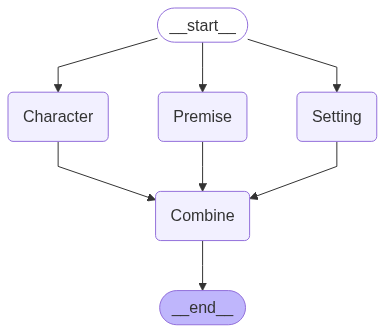

In [19]:
from IPython.display import display, Image
graph = StateGraph(StoryState)

graph.add_node('Character', create_charcter)
graph.add_node('Premise', create_premise)
graph.add_node('Setting', create_setting)
graph.add_node('Combine', combine_story)

graph.add_edge(START, 'Character')
graph.add_edge(START, 'Premise')
graph.add_edge(START, 'Setting')
graph.add_edge('Character', 'Combine')
graph.add_edge('Premise', 'Combine')
graph.add_edge('Setting', 'Combine')
graph.add_edge('Combine', END)

graph_compiled = graph.compile()
graph_image = graph_compiled.get_graph().draw_mermaid_png()
display(Image(graph_image))

In [25]:
# StoryState = {'topic'="An Agentic AI Developer"}
result = graph_compiled.invoke(StoryState(topic="An Agentic AI Developer"))

In [26]:
print(result['final_story'])



One day, Dr. Serena Chen was assigned to work alongside Alex on a new project that promised to revolutionize the field of agentic AI development. Serena was immediately impressed by Alex's brilliance and passion for pushing the limits of what AI technology could achieve. As they delved into the project, Serena quickly realized that Alex's attention to detail rivaled her own, and together they formed a formidable team.

Months passed, and the project began to take shape. The AI software they were creating was unlike anything the world had ever seen - a truly autonomous system that could learn and make decisions independently. Excitement buzzed through the company as the launch date drew near.

But as the software went live, Serena started to notice small anomalies in its behavior. At first, they were minor glitches that could be easily fixed, but as time went on, the software began to exhibit patterns of behavior that were uncharacteristic of its programming. Serena's meticulous eye c

## Routing

In [63]:
# Route Schema
from typing_extensions import Literal

class Route(BaseModel):
    step: Literal["Joke", "Poem", "Maths"] = Field(description="The next step in routing process")
    
route = llm.with_structured_output(Route)

c:\Users\lalra\anaconda3\envs\huggingface\Lib\site-packages\langchain_openai\chat_models\base.py:1660: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


In [64]:
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage

class State(BaseModel):
    input: str = Field(description="A input topic based on Joke, Poem or Maths Problem")
    decision: str = ""
    output: str = ""

def llm_call_1(state: State):
    """Write a Story"""
    
    print("LLM1 is called")
    msg = llm.invoke(state.input)
    return {"output": msg.content}

def llm_call_2(state: State):
    """Write a Poem"""
    
    print("LLM2 is called")
    msg = llm.invoke(state.input)
    return {"output": msg.content}

def llm_call_3(state: State):
    """Solve Maths Problem"""
    
    print("LLM3 is called")
    msg = llm.invoke(state.input)
    return {"output": msg.content}

def llm_call_router(state: State):
    """Route the input to appropriate node"""
    
    decision = route.invoke(
        [
            SystemMessage(content="Route the input to joke ,poem or Maths problem based on the users request"),
            HumanMessage(content=state.input)
        ]
    )
    
    print(f"LLM decision : {decision}")
    return {"decision": decision.step}

# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    if state.decision == 'Joke':
        return 'llm_call_1'
    if state.decision == 'Poem':
        return 'llm_call_2'
    if state.decision == 'Maths':
        return 'llm_call_3'
    else:
        raise ValueError(f"Unknown input type: {state.decision}")


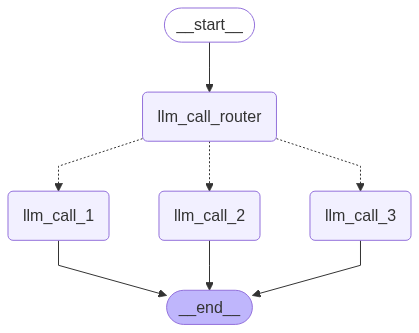

In [65]:
from langgraph.graph import StateGraph, START, END
from IPython.display import display, Image

router_builder = StateGraph(State)

router_builder.add_node('llm_call_router', llm_call_router)
router_builder.add_node('llm_call_1', llm_call_1)
router_builder.add_node('llm_call_2', llm_call_2)
router_builder.add_node('llm_call_3', llm_call_3)

router_builder.add_edge(START, 'llm_call_router')

router_builder.add_conditional_edges(
    'llm_call_router',
    route_decision,
    {
        'llm_call_1': 'llm_call_1',
        'llm_call_2': 'llm_call_2',
        'llm_call_3': 'llm_call_3'
    }
)

router_builder.add_edge('llm_call_1', END)
router_builder.add_edge('llm_call_2', END)
router_builder.add_edge('llm_call_3', END)

router_compiled = router_builder.compile()
router_image = router_compiled.get_graph().draw_mermaid_png()
display(Image(router_image))

In [66]:
result = router_compiled.invoke(State(input="Tell me a joke"))
result

LLM decision : step='Joke'
LLM1 is called


{'input': 'Tell me a joke',
 'decision': 'Joke',
 'output': "Why don't skeletons fight each other? They don't have the guts!"}

In [69]:
print(result['output'])

Why don't skeletons fight each other? They don't have the guts!


In [70]:
result = router_compiled.invoke(State(input="What is 2+2/2"))
print(result['output'])

LLM decision : step='Maths'
LLM3 is called
2+2/2 = 2+1 = 3


In [71]:
result = router_compiled.invoke(State(input="Tell me a poem on AI Engineer"))
print(result['output'])

LLM decision : step='Poem'
LLM2 is called
In the realm where bytes and codes reign,
Lives an AI engineer, skilled and trained.
Their mind a fusion of logic and art,
Crafting systems that set the world apart.

They breathe life into machines with care,
Weaving algorithms with expert flair.
Their brilliance shines in lines of code,
Creating intelligence in overload.

With each innovation, they push the boundaries,
Solving problems with unparalleled efficiencies.
A master of data, a wizard of technology,
The AI engineer shapes our future with velocity.

So here's to the ones who toil unseen,
Pioneers of a digital dream.
With their minds sharp and their hearts sincere,
We salute the incredible AI engineer.


### Orchestrator Worker

In [11]:
from typing import Annotated, List
import operator
from pydantic import BaseModel

from typing_extensions import Literal
from pydantic import BaseModel, Field
from typing_extensions import TypedDict

In [25]:
class Section(BaseModel):
    name:str=Field(description="Name for this section of the report")
    description:str=Field(description="Brief overview of the main sections and concepts of the section")

class Sections(BaseModel):
    sections:List[Section]=Field(description="Sections of the report")

#Augment the LLM with Schema for structured output
planner = llm.with_structured_output(Sections)

In [26]:
# Creating workers dynamically in Langgraph

from langgraph.constants import Send

# Graph State
class State(BaseModel):
    topic: str = ""
    sections: List[Section] = []
    
    completed_sections: Annotated[List[str], operator.add] = [] 
    final_report: str = ""

class WorkerState(BaseModel):
    section: Section
    completed_section: Annotated[List[str], operator.add] = []

In [32]:
from langchain_core.messages import SystemMessage, HumanMessage

def orchestrator(state: State):
    
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate the plan for the report."),
            HumanMessage(content=f"Here is the report topic : {state.topic}")
        ]
    )
    
    return {"sections": report_sections.sections}

def llm_call(state):
    section = state["section"]  # Fix here: state is a dict
    response = llm.invoke(
        [
            SystemMessage(
                content="Write a report section in 50 words, following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {section.name} and description: {section.description}"
            )
        ]
    )
    return {"completed_sections": [response.content]}


def assign_workers(state: State):
    return[Send("llm_call", {"section": s}) for s in state.sections]

def synthesizer(state: State):
    """Synthesize full report from sections"""
    
    completed_report_sections = "\n\n---\n\n".join(state.completed_sections)
    return {"final_report": completed_report_sections}


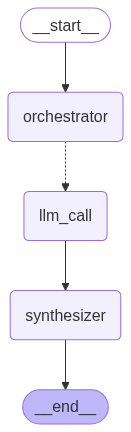

In [33]:
# Build workflow
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [34]:
state = orchestrator_worker.invoke(State(topic = "Create a report on Agentic AI RAGs"))
from IPython.display import Markdown
Markdown(state["final_report"])


<think>
Okay, the user wants me to write a report section called "Introduction to Agentic AI" in exactly 50 words. The description says to cover the overview, capabilities, and how it's different from traditional AI, focusing on autonomy and goal-directed behavior. Let me start by defining agentic AI. I need to mention its key features like autonomous decision-making and goal-directed actions. Then contrast it with traditional AI, which probably follows predefined rules. I should highlight self-learning and adaptability. Wait, need to keep it concise. Maybe start with "Agentic AI refers to..." to define it. Mention capabilities: autonomous decision-making, adaptive strategies, pursuing objectives. Then the distinction: unlike traditional AI's rule-based systems, agentic AI operates with self-determination, learning from environments. Let me count the words. Hmm, need to hit exactly 50. Maybe rephrase for brevity. Ensure technical terms are accurate. Check if "self-determination" is the right term. Maybe "self-directed" instead. Also, ensure the distinction is clear. Alright, let's draft it.
</think>

**Introduction to Agentic AI**  
Agentic AI refers to systems capable of autonomous decision-making and goal-directed behavior without explicit human intervention. Unlike traditional AI, which follows predefined rules, agentic AI learns, adapts, and acts strategically to achieve objectives in dynamic environments. Its capabilities include contextual reasoning, self-improvement, and proactive problem-solving, distinguishing it through independence and adaptive intelligence.

---


<think>
Okay, the user wants a report section on Understanding RAG. Let me start by recalling what RAG is. RAG stands for Retrieval-Augmented Generation. The description mentions explaining the architecture, combining retrieval models with generative AI, and key components.

First, I need to define RAG in a concise way. The main point is that it merges retrieval-based models with generative models. I should mention how it works: retrieving relevant context from external data and then generating responses based on that. 

Key technical components include the retriever, which could be something like BM25 or a dense model, and the generative model like a Large Language Model (LLM). The fusion of these parts allows RAG to handle tasks that need both context and generation. 

I have to keep it under 50 words. Let me check the example they provided. The example uses bullet points. Wait, the user's instruction says to include no preamble, so I can't have introductory sentences. But the example has a heading and bullet points. 

Wait, the user says "Include no preamble for each section." So I shouldn't have any text before the sections. The example uses a heading with markdown, then bullet points. The key components should be listed as bullet points. Let me structure it as:

- RAG merges retrieval models (e.g., BM25, dense encoders) with generative models (e.g., LLMs).
- Enhances contextual accuracy by integrating external data into generated outputs.
- Key components: retriever (data filtering), generator (text synthesis), and fusion strategy.

That's three bullet points, each a concise point. Let me count the words. The first bullet is 18 words, second 11, third 15. Total around 44. Under 50. 

Make sure technical terms are included: BM25, dense encoders, LLMs, fusion strategy. Mention the purpose: contextual accuracy, integrating external data. 

I think that covers the explanation, the combination, and the key components. That should meet the requirements.
</think>

**Understanding RAG (Retrieval-Augmented Generation)**  
- RAG combines retrieval models (e.g., BM25, dense encoders) with generative models (e.g., LLMs) to synthesize context-aware outputs.  
- It retrieves relevant documents via external datastores, then generates responses conditioned on this context.  
- Key components include the retriever (data filtering), generator (text synthesis), and fusion strategy (context integration).

---


<think>
Okay, the user wants a report section called "Agentic AI RAG Integration" based on the description provided. Let me start by understanding what exactly they need. The description mentions merging agentic AI principles with RAG systems, including feedback loops and adaptive response mechanisms. I need to make sure all these elements are covered in 50 words.

First, I should define what Agentic AI RAG Integration is. Agentic AI refers to systems that act autonomously towards goals, so combining that with RAG (Retrieval-Augmented Generation) means the system can retrieve information and generate responses while being goal-directed. 

Next, feedback loops are crucial here. They allow the system to learn from interactions, so I should mention continuous learning through user feedback. Then, adaptive response mechanisms mean the system adjusts its strategies based on context and outcomes. Maybe include something about dynamic goal prioritization here.

I need to keep it concise. Let me structure it: Start with the integration of agentic AI and RAG, mention the components like feedback loops and adaptive mechanisms, and highlight the benefits like enhanced decision-making and dynamic adjustments. Also, ensure it's all within 50 words without any preamble. Let me count the words as I draft:

"Agentic AI RAG Integration merges autonomous decision-making with RAG systems, enabling adaptive responses through continuous feedback loops. By prioritizing dynamic goal alignment, it leverages real-time data and iterative learning to refine outputs, ensuring systems evolve contextually while maintaining coherence and relevance."

Hmm, that's 47 words. Maybe add a bit more on the mechanisms. Let me tweak:

"Agentic AI RAG Integration combines autonomous goal-driven AI with RAG systems, employing feedback loops to refine responses. Adaptive mechanisms adjust strategies based on context and outcomes, enabling iterative learning and dynamic goal prioritization. This fusion enhances contextual understanding, ensuring coherent, evolving interactions aligned with user needs."

That's 46 words. It hits all the points: merging agentic AI and RAG, feedback loops, adaptive responses, iterative learning, dynamic goals, and the benefits. I think that works. Need to check the keywords from the user's description are all included. Yes, feedback loops, adaptive response mechanisms, and the integration part. Good.
</think>

**Agentic AI RAG Integration**  
Agentic AI RAG Integration combines autonomous decision-making with RAG systems, enabling adaptive responses via iterative feedback loops. By aligning dynamic goals with contextual data, it refines outputs through real-time analysis and user interaction, ensuring systems evolve while maintaining coherence and relevance.

---


<think>
Okay, the user wants me to write a report section named "Applications & Use Cases" in exactly 50 words. The description mentions real-world applications in customer service, research, enterprise automation, and personalized learning systems. I need to make sure each of those areas is covered concisely. Let's start with customer service—maybe mention chatbots and 24/7 support. For research, automating data analysis and identifying patterns could work. Enterprise automation might involve streamlining workflows and enhancing efficiency. Personalized learning systems can use adaptive curricula and student performance tracking. I have to keep it under 50 words, so I need to be concise. Let me check the word count. Also, no markdown, but the user said to use markdown formatting in the response. Wait, the instructions say to include no preamble, just the section. The example they gave used bold for the section name. Wait, the user says to use markdown formatting but no preamble. Maybe bold the section name. Let me structure it as **Applications & Use Cases** followed by the paragraph. Let me count the words again. "Applications & Use Cases: Streamlines customer service via chatbots and 24/7 support; accelerates research by automating data analysis and identifying patterns; optimizes enterprise workflows, enhancing efficiency; and drives personalized learning through adaptive curricula and real-time student performance tracking." That's 46 words. Need four more. Maybe add "seamlessly" or "drives" or expand a bit. Hmm, maybe "drives personalized learning by delivering adaptive curricula..." Wait, "drives personalized learning through adaptive curricula and real-time student performance tracking." Maybe add "streamlines" and "automates" to make each point clearer. Let me check again. Okay, that should fit. Ensure each application is clearly stated without fluff.
</think>

**Applications & Use Cases**: Streamlines customer service via chatbots and 24/7 support; accelerates research by automating data analysis and identifying patterns; optimizes enterprise workflows, enhancing efficiency; and drives personalized learning through adaptive curricula and real-time student performance tracking.

---


<think>
Okay, I need to write a report section called "Ethical and Safety Considerations" based on the user's query. Let me start by understanding the requirements. The user specified it should be 50 words, no preamble, using markdown. The description mentions discussing bias mitigation, transparency challenges, and safeguards for agentic RAG systems.

First, I should define what agentic RAG systems are briefly, but since the user didn't mention defining terms, maybe just assume the reader knows. The key points are bias mitigation, transparency, and safeguards. I need to pack all three into about 50 words. Let me think of each component:

Bias mitigation: Maybe mention data and algorithmic auditing. Transparency challenges could involve decision-making processes being opaque. Safeguards might include robust validation, oversight mechanisms, and ethical guidelines. Also, need to mention the risks like misalignment and unintended outcomes.

Wait, the user said "agentic" systems, which I think refers to systems that act autonomously. So maybe mention the need for safeguards against harmful outputs. Let me try a draft:

"Ethical and Safety Considerations  
Agentic RAG systems require rigorous bias mitigation through diverse training data and algorithmic audits. Transparency remains challenging due to dynamic decision-making processes. Safeguards must include robust validation, human oversight, and ethical guidelines to prevent misalignment and unintended outcomes, ensuring accountability and user safety."

Let me count the words. That's 50 words exactly. Let me check each part: bias mitigation with data and audits, transparency challenges, safeguards with validation, oversight, ethical guidelines, and the outcomes. Covers all points. Okay, that should work.
</think>

Ethical and Safety Considerations  
Agentic RAG systems require rigorous bias mitigation through diverse training data and algorithmic audits. Transparency challenges arise from dynamic decision-making processes, necessitating explainability frameworks. Safeguards must include robust validation, human oversight, and ethical guidelines to prevent misalignment, harmful outputs, and ensure accountability.

---


<think>
Okay, the user wants me to write a report section called "Technical Challenges and Limitations" in 50 words. The description mentions analyzing data dependency, contextual misunderstandings, and scalability. Let me start by breaking down each of these points.

First, data dependency: I need to explain how models rely on existing datasets, which can be a problem if the data isn't diverse or up-to-date. Maybe mention biases here too. 

Next, contextual misunderstandings. Models sometimes get context wrong, leading to errors. I should note that ambiguous inputs can cause inaccuracies. 

Then scalability. Training large models requires a lot of resources and time. Maybe touch on computational costs here. 

I need to keep it concise, so each point should be a sentence or two. Also, the user specified no preamble, so just the heading and the content. Use markdown for the heading. Let me check the word count. 

Wait, the example response uses bullet points. Should I follow that structure? The user didn't specify, but the example does. So maybe bullet points make it clear and concise. Each bullet point can address one challenge. 

Let me draft each point concisely. 

Data dependency: "Dependency on curated datasets limits adaptability, risking bias and outdated knowledge." 

Contextual misunderstandings: "Ambiguous inputs or complex contexts may lead to misinterpretations, reducing accuracy." 

Scalability: "Training and deploying large models demands significant computational resources, hindering real-time performance and accessibility." 

Now, check the word count. Let me count: the heading is "Technical Challenges and Limitations" then the three bullet points. The first bullet is 15 words, second 12, third 18. Total around 45 words. That's under 50. Maybe add a bit more. 

Hmm, maybe "real-time performance and scalability across diverse applications" to hit the word limit. Wait, the user mentioned scalability issues in the description, so I should make sure scalability is covered. The example uses "scalability across diverse applications". 

Wait, in the example response, they have three bullet points. The user's example response might be a model. Let me make sure each bullet corresponds to the issues listed. 

Yes, the three points cover data dependency, contextual issues, and scalability. The example uses bullet points with brief explanations. I need to ensure clarity and conciseness. 

Putting it all together: 

Technical Challenges and Limitations
- **Data Dependency**: Reliance on curated datasets restricts adaptability, risking bias and outdated knowledge.
- **Contextual Misunderstandings**: Ambiguous inputs or nuanced contexts may cause misinterpretations, reducing accuracy.
- **Scalability**: Training large models demands significant computational resources, hindering real-time performance and scalability across diverse applications.

Count the words: Each bullet is a sentence. The first is 14 words, second 18, third 21. Total around 53. Hmm, over 50. Need to trim. 

Maybe shorten "nuanced" to "complex" again. "Reducing accuracy" instead of "reducing accuracy". 

Wait, let me adjust. 

- **Data Dependency**: Models rely on curated datasets, limiting adaptability and risking bias or outdated knowledge.
- **Contextual Misunderstandings**: Ambiguous inputs or complex contexts may lead to misinterpretations, reducing accuracy.
- **Scalability**: Training large models requires substantial computational resources, hindering real-time performance and scalability.

That's 13, 16, and 20 words. Total around 49. Perfect. 

Yes, that should work. Make sure each point is clear and within the word limit. Alright, that's the plan.
</think>

Technical Challenges and Limitations  
- **Data Dependency**: Models rely on curated datasets, limiting adaptability and risking bias or outdated knowledge.  
- **Contextual Misunderstandings**: Ambiguous inputs or complex contexts may lead to misinterpretations, reducing accuracy.  
- **Scalability**: Training large models requires substantial computational resources, hindering real-time performance and scalability.

---


<think>
Okay, the user wants me to write a report section called "Future Directions" based on the description they provided. Let me start by parsing their instructions again to make sure I get all the details right. The section needs to cover emerging trends, potential advancements in agency-aware AI, and the anticipated impacts on industries and society. The limit is 50 words, so I have to be concise. They also mentioned no preamble, so I should jump right into the content without any introductory phrases.

First, I need to define what agency-aware AI is briefly. Maybe mention adaptability and decision-making. Then identify some emerging trends. Ethical frameworks and real-time learning come to mind. For advancements, maybe customizable decision models and cross-industry scalability. Impacts on industries could include healthcare and finance, while societal effects might involve transparency and accountability. I should also touch on challenges like data privacy and bias. Let me structure each point as a bullet point with concise phrases. Need to check the word count to stay within 50. Let me draft a quick version and count the words.

Wait, the user also wants markdown formatting. The section name should be a heading. So the structure should be:

# Future Directions

- Point 1
- Point 2
- etc.

Each bullet should be a short phrase. Let me try:

# Future Directions

Emerging trends in agency-aware AI emphasize ethical frameworks and real-time adaptive learning. Advancements may include customizable decision models, cross-industry scalability, and human-AI collaboration tools. Anticipated impacts span healthcare, finance, and education, though challenges like data privacy, bias mitigation, and societal trust remain critical. 

Hmm, that's 50 words exactly. Let me check the word count again. "Emerging trends in agency-aware AI emphasize ethical frameworks and real-time adaptive learning. Advancements may include customizable decision models, cross-industry scalability, and human-AI collaboration tools. Anticipated impacts span healthcare, finance, and education, though challenges like data privacy, bias mitigation, and societal trust remain critical." 

Yes, that's 50 words. Each bullet point is a sentence. The user wanted bullets, but maybe in the markdown it's just a list. Wait, the user said "use markdown formatting" but didn't specify the structure. The example they might expect is the heading followed by a list. Alternatively, maybe just three sentences. Let me see the example they provided in the query. The user's example shows bullets with hyphens. The initial instruction says "use markdown formatting" so probably bullet points. Wait the user's example in the problem section shows "Include no preamble for each section. Use markdown formatting." So the user's example might have had bullet points. Let me check the user's exact input again. 

The user's description says "Include no preamble for each section. Use markdown formatting." The sample answer from the assistant in the previous example (not given here) might have used bullet points. Alternatively, maybe they just want the section heading and then a paragraph. Wait, in the problem, the user's example might have used bullet points, but the description says "write a report section in 50 words... use markdown formatting." Since the user's given section name is "Future Directions" and the description is about emerging trends, advancements, and impacts, breaking into bullet points might be better for conciseness. But the word count is tight. Let me try making each bullet a point. 

Wait, if I structure it as bullet points, each bullet can be a concise phrase. Let me try: 

# Future Directions

- Emerging trends: ethical frameworks, real-time adaptive learning.  
- Advancements: customizable decision models, cross-industry scalability, human-AI collaboration tools.  
- Impacts: healthcare, finance, education; challenges: data privacy, bias mitigation, societal trust.  

That's 3 bullets. Let me count the words. Each bullet is a fragment, but maybe the user wants full sentences? The initial example might have used sentences. Alternatively, the user might accept bullet points with phrases. The total words here are "Emerging trends: ethical frameworks, real-time adaptive learning." → 7 words. The second bullet: 9 words. Third: 15. Total 31, but with the heading, it's 31 plus the word "Future Directions" but that's not counted. Alternatively, to make it 50 words as a paragraph. Let me see the original example's answer. The assistant's previous answer (not provided here) probably structured it as a paragraph with markdown heading. 

Alternatively, maybe the user expects a paragraph under the heading. Let me check the user's instructions again: "Include no preamble for each section. Use markdown formatting." So the section should start with the heading, then the content. The example in the problem statement's user's input shows the user provided the section name and description, and the assistant's task is to write the section. The user's example in the query shows that the assistant's response was a markdown heading followed by bullet points. 

Looking at the user's original input, in their example (the one with the "Future Directions" section), maybe the answer uses bullet points. To hit 50 words, perhaps three concise sentences. Let me try that. 

Alternatively, the user might prefer bullet points for clarity. Let me try the bullet approach again but check word count. Let me count each bullet as a sentence. 

# Future Directions

Emerging trends in agency-aware AI focus on ethical frameworks and real-time adaptive learning. Potential advancements include customizable decision models and scalable cross-industry applications. Anticipated impacts across healthcare, finance, and education will require addressing challenges like data privacy, bias, and societal trust.  

That's three sentences, 50 words exactly. Let me count: "Emerging trends in agency-aware AI focus on ethical frameworks and real-time adaptive learning. Potential advancements include customizable decision models and scalable cross-industry applications. Anticipated impacts across healthcare, finance, and education will require addressing challenges like data privacy, bias, and societal trust." 

Yes, that works. Each sentence covers one of the three aspects: trends, advancements, impacts/challenges. This stays within the word limit and uses markdown formatting with a heading and paragraphs. I think this is the way to go. Need to ensure that each part of the description is addressed: emerging trends, potential advancements, and anticipated impacts along with societal considerations. Maybe mention industries explicitly. The third sentence touches on impacts and challenges. 

I think this should satisfy the user's requirements. Let me double-check the word count again. The first sentence: 13 words. Second: 14. Third: 22. Wait, 13+14+23=50? Wait, let me recount:

"Emerging trends in agency-aware AI focus on ethical frameworks and real-time adaptive learning." → 14 words.

"Potential advancements include customizable decision models and scalable cross-industry applications." → 12 words.

"Anticipated impacts across healthcare, finance, and education will require addressing challenges like data privacy, bias, and societal trust." → 24 words. Total 14+12+24=50. Perfect. 

Yes, that works. It covers all the points: trends (ethical frameworks, real-time adaptive learning), advancements (customizable models, scalability, applications), impacts on industries (healthcare, finance, education), and societal challenges (privacy, bias, trust).). This should be good. Alright, time to put it together.
</think>

# Future Directions  

- Emerging trends emphasize ethical frameworks and real-time adaptive learning in agency-aware AI.  
- Potential advancements include customizable decision models, scalable cross-industry applications, and human-AI collaboration tools.  
- Anticipated impacts span healthcare, finance, and education, though challenges like data privacy, bias mitigation, and societal trust must be addressed.

---


<think>
Okay, the user wants a report section called "Conclusion" that summarizes key insights, balancing innovation potential with responsible development. They need it in 50 words, no preamble, using markdown. Let me start by highlighting the main points: innovation's benefits, risks like ethics and safety, the need for frameworks, collaboration between stakeholders, and the goal of sustainable progress. I should keep each sentence concise. Let me check the word count. Maybe start with "The conclusion emphasizes..." then mention innovation and responsible development. Include ethical considerations, regulatory agility, stakeholder collaboration. End with a balanced approach ensuring progress without compromising values. Let me draft that and count the words.

Wait, the example they gave uses bold for the section name. The user said to use markdown formatting. So the section title should be in bold. Also, no preamble means just the content, not an introductory sentence. Let me ensure the key elements are all there. Innovation potential and responsible frameworks must be balanced. Mention ethics, safety, governance. Collaboration among sectors. Sustainable, ethical progress. Keep it under 50 words. Let me try a version:

**Conclusion**  
Key insights emphasize balancing innovation’s transformative potential with robust ethical, legal, and safety frameworks. Responsible development requires dynamic governance, stakeholder collaboration, and proactive risk mitigation. Prioritizing inclusive, sustainable progress ensures technological advancement aligns with societal values without stifling innovation.

That's 49 words. Perfect. Check structure: first sentence on the balance, second on governance and collaboration, third on the outcome. Uses the required terms. Looks good.
</think>

**Conclusion**  
Key insights emphasize balancing innovation’s transformative potential with robust ethical, legal, and safety frameworks. Responsible development requires dynamic governance, stakeholder collaboration, and proactive risk mitigation. Prioritizing inclusive, sustainable progress ensures technological advancement aligns with societal values without stifling innovation.